In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

print("loaded packages\n")

loaded packages



In [3]:
coral_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/richness_qc_clean.csv")
met_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/metabolite_clean.csv")

coral_df['scleractinia'] = np.where(coral_df['host_order'] == 'Scleractinia', 1, 0)
met_df['refined_origin'] = met_df['refined_origin'].str.replace('Host', 'Coral')
met_df = met_df[met_df['refined_origin'] == 'Coral']

print("loaded and cleaned data\n")

X = coral_df[coral_df.columns.intersection(met_df['metabolite'])]
y = coral_df['scleractinia']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88, stratify=y)

/tmp/ipykernel_425501/2399423384.py:1: DtypeWarning: Columns (8,17) have mixed types. Specify dtype option on import or set low_memory=False.
  coral_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/richness_qc_clean.csv")


loaded and cleaned data



### Feature Selection

In [4]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif

## variance threshold doesn't remove enough testing Kbest and percentile

In [5]:
# Initialize a dictionary to store the dataframes
importance_storage = {}

# Define your datasets and models
# We can get 100% accuracy using k=80
datasets = {
    "KBest": SelectKBest(f_classif, k=3623),
    # "Percentile_5": SelectPercentile(f_classif, percentile=5)
}

models = {
    "RandomForest": RandomForestClassifier(random_state=88, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=88, use_label_encoder=False, eval_metric='logloss')
}

# Original feature names from the intersection
feature_names = coral_df.columns.intersection(met_df['metabolite']).values

for d_name, selector in datasets.items():
    selector.fit(X_train, y_train)
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
    
    mask = selector.get_support()
    selected_features = feature_names[mask]
    
    for m_name, model in models.items():
        model.fit(X_train_sel, y_train)
        y_pred = model.predict(X_test_sel)
        
        print(f"\n{m_name} on {d_name}")
        print(confusion_matrix(y_test, y_pred))
        
        feat_imp_df = pd.DataFrame({
            'Metabolite': selected_features,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
        
        importance_storage[f"{m_name}_{d_name}"] = feat_imp_df

# importance_storage

/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 208  322  330  441  514  798 1015 1234 2124 2781 2900 3034 3156] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



RandomForest on KBest
[[28  0]
 [ 0 86]]


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:12:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost on KBest
[[28  0]
 [ 1 85]]


### Perm importance collinear features

In [6]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict

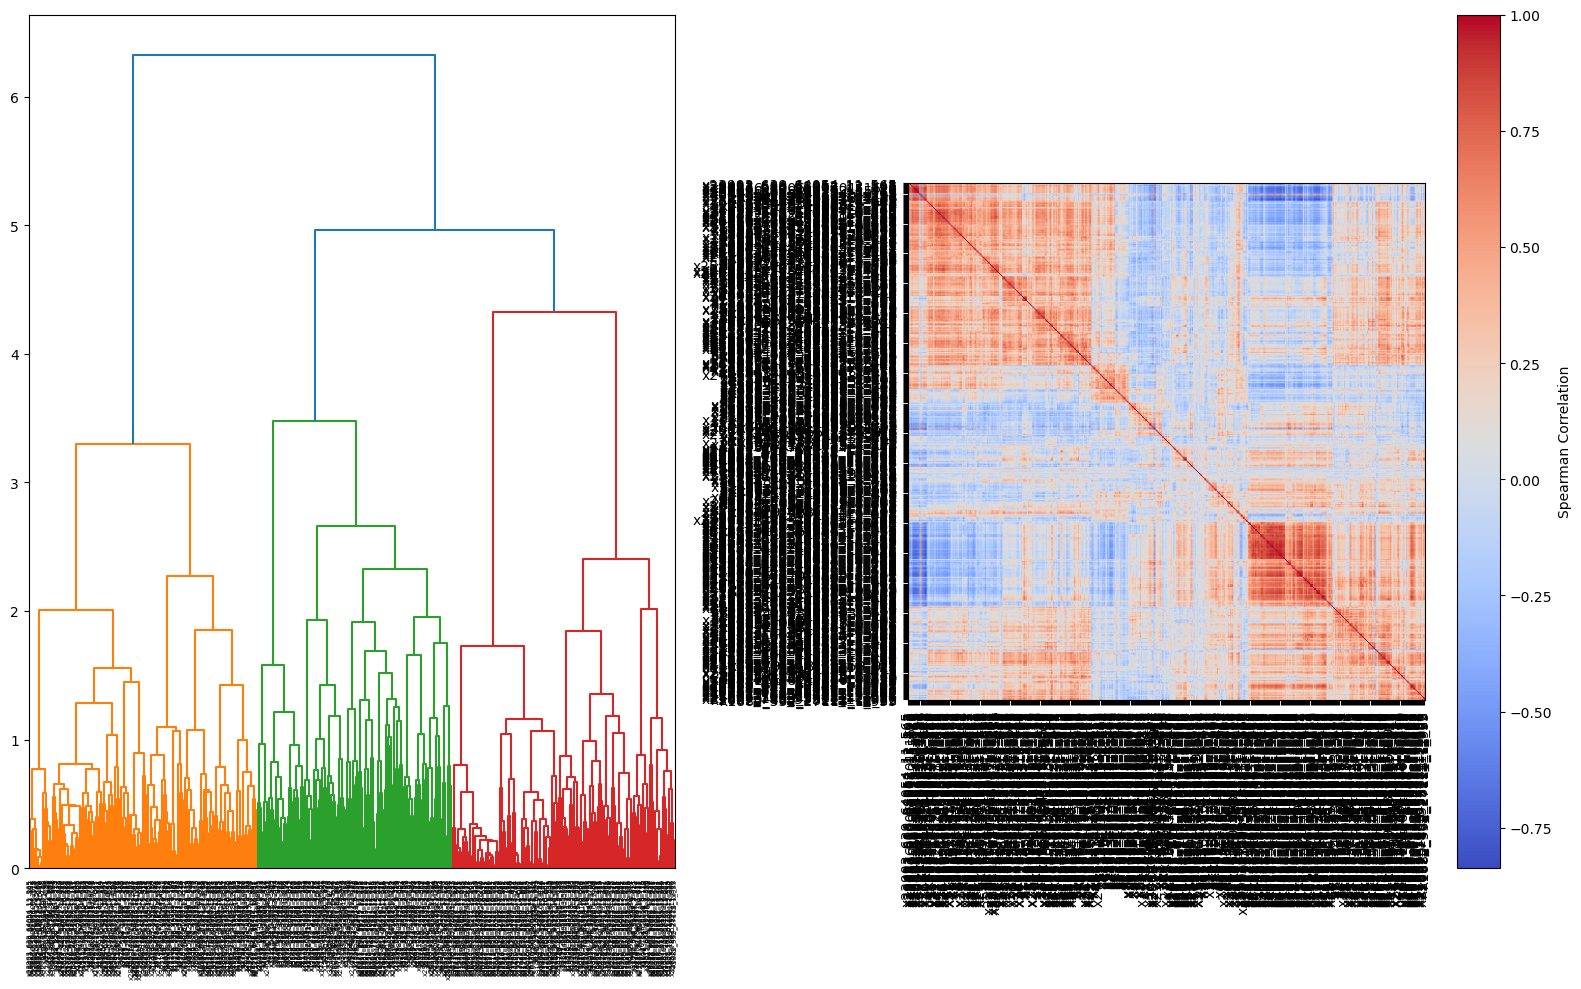

In [10]:
top_mets = importance_storage["RandomForest_KBest"].head(500)['Metabolite'].values
# top_mets = importance_storage["XGBoost_KBest"].head(500)['Metabolite'].values

X_df = pd.DataFrame(X, columns=coral_df.columns.intersection(met_df['metabolite']))
X_subset = X_df[top_mets]

corr = spearmanr(X_subset).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

dendro = hierarchy.dendrogram(
    dist_linkage, labels=top_mets.tolist(), ax=ax1, leaf_rotation=90
)

im = ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap='coolwarm')
ax2.set_xticks(np.arange(len(top_mets)))
ax2.set_yticks(np.arange(len(top_mets)))
ax2.set_xticklabels([top_mets[i] for i in dendro["leaves"]], rotation=90)
ax2.set_yticklabels([top_mets[i] for i in dendro["leaves"]])

fig.colorbar(im, ax=ax2, label='Spearman Correlation')
fig.tight_layout()
plt.show()

In [11]:
from collections import defaultdict
from scipy.cluster import hierarchy

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")

cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

selected_features_indices = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = feature_names[selected_features_indices]

print(f"Reduced feature set from {len(feature_names)} to {len(selected_features_names)} clusters.")
print("Selected feature names after clustering:")
for name in selected_features_names:
    print(name)

X_train_sel = X_train[:, selected_features_indices]
X_test_sel = X_test[:, selected_features_indices]

clf_sel = RandomForestClassifier(random_state=88, n_jobs=-1)
# clf_sel = XGBClassifier(random_state=88, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
clf_sel.fit(X_train_sel, y_train)

accuracy = clf_sel.score(X_test_sel, y_test)
print(f"Baseline accuracy on test data with redundant features removed: {accuracy:.2f}")



Reduced feature set from 3623 to 54 clusters.
Selected feature names after clustering:
x22863_768_59077_10_971
x3156_482_36064_2_937
x20449_766_57519_9_667
x23789_794_60652_11_52
x24987_796_62223_11_912
x26021_752_55957_12_218
x26056_772_62178_12_23
x6230_466_32962_3_999
x25734_822_63619_12_121
x3140_504_34195_2_931
x24359_782_60661_11_724
x26387_806_61119_12_325
x20473_788_55523_9_685
x21104_667_51515_9_991
x22804_780_58887_10_928
x4860_546_35343_3_581
x11988_492_34809_6_02
x27910_716_55909_12_685
x14474_640_55096_7_072
x29010_632_59734_12_997
x4603_428_37317_3_509
x25740_808_62031_12_113
x26054_774_54083_12_234
x3523_508_37638_3_101
x34772_648_7388_14_298
x19872_828_55032_9_343
x26370_829_68761_12_322
x6270_488_31164_4_015
x17460_1195_91181_8_298
x4177_524_37207_3_374
x20959_830_56547_9_927
x31765_656_59464_13_624
x23839_960_65237_11_539
x21630_764_55668_10_29
x18438_668_58271_8_65
x3862_580_3978_3_26
x26004_775_54372_12_229
x67_347_01414_0_66
x17930_681_49354_8_474
x28727_950_53237_

In [9]:
selected_features_names

array(['x22863_768_59077_10_971', 'x3156_482_36064_2_937',
       'x19279_643_51751_9_054', 'x22902_794_60499_10_997',
       'x26021_752_55957_12_218', 'x22281_518_49367_10_602',
       'x26056_772_62178_12_23', 'x6230_466_32962_3_999',
       'x25734_822_63619_12_121', 'x22257_558_48585_10_595',
       'x27615_824_65407_12_621', 'x24838_770_60774_11_835',
       'x22869_771_59779_10_97', 'x26360_766_62066_12_319',
       'x19261_1286_02582_9_046', 'x22799_790_57142_10_937',
       'x23841_932_62245_11_539', 'x26387_806_61119_12_325',
       'x6084_532_3736_3_947', 'x19310_665_49861_9_069',
       'x6689_344_35256_4_145', 'x20473_788_55523_9_685',
       'x31046_620_59826_13_466', 'x29153_834_64268_13_004',
       'x27982_604_56684_12_699', 'x4496_496_37644_3_479',
       'x25776_818_60241_12_14', 'x22037_768_59132_10_443',
       'x30258_690_60437_13_288', 'x23028_752_59618_11_083',
       'x21104_667_51515_9_991', 'x19452_766_57545_9_157',
       'x22804_780_58887_10_928', 'x31750_6